In [3]:
################################## LIBRARIES ################################## 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.preprocessing import MultiLabelBinarizer
from sentence_transformers import SentenceTransformer
from sklearn_extra.cluster import KMedoids
from bertopic import BERTopic
from ast import literal_eval
from pathlib import Path
from umap import UMAP
import pandas as pd
import numpy as np
import regex as re
import DrainMethod
import contextlib
import hdbscan
import pickle
import sys
import os

############################## AUXILIARY METHODS ############################## 

# Code for reading HuggingFace token

def get_huggingface_token():
    f = open("huggingface_token.txt", "r")
    return (f.read())

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors_TFIDF.vec')
    path = Path(path_to_file)
    vectors_tfidf = []

    # if (path.is_file()):
    #     vectors_tfidf = pickle.load(open(path_to_file, 'rb'))
    # else:
    #     # Using TFIDF Vectorizer 
    #     print("Iniciando encode")
    #     tr_idf_model  = TfidfVectorizer()
    #     vectors_tfidf = tr_idf_model.fit_transform(raw_content)
    #     pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))
    
    # Using TFIDF Vectorizer 
    tr_idf_model  = TfidfVectorizer()
    vectors_tfidf = tr_idf_model.fit_transform(raw_content)
    pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))

    return vectors_tfidf

def creates_lists(clusterer):
    ## General Parameters

    cluster_idxs = []
    cluster_lines = []
    output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
    output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

    ## Code

    # Reads parameters list
    full_df = pd.read_csv(output_csv)
    elem_df = full_df["EventTemplate"]

    # Creates blank lists
    for elem in range (clusterer.labels_.max()+1):
        cluster_idxs.append([])
        cluster_lines.append([])

    # Populate the lists with cluster elements
    for idx, elem in np.ndenumerate(clusterer.labels_):
        if elem != -1:
            cluster_idxs[elem].append(idx[0])
            cluster_lines[elem].append(elem_df[idx[0]])
        
    return (cluster_idxs, cluster_lines)

################################# MAIN METHODS ################################ 

# Code for reading HuggingFace token

def get_huggingface_token():
    f = open("huggingface_token.txt", "r")
    return (f.read())

# Parse logs using Drain

def parse_logs(st=0.5, depth=5):
    st = st # Drain similarity threshold
    depth = depth # Max depth of the parsing tree

    ## Code
    parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
    parser.parse(log_file)

    parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   

# Creates embeddings for log file
def transform(logName):
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

# Creates distance matrix, using Euclidean distance
def create_distance_matrix(vector_df):
    # Using Euclidean Distance between the rows of the TFIDF Matrix
    tfidf_distance = pairwise_distances(vector_df, metric="euclidean", n_jobs=-1)
    #Normalizes Distance Matrix with Min-Max
    min_val = np.min(tfidf_distance)
    max_val = np.max(tfidf_distance)
    tfidf_distance = (tfidf_distance - min_val) / (max_val - min_val)
    return (tfidf_distance)

# Creates variable matrix, using Jaccard distance
def create_variable_matrix():
    ## General Parameters
    output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
    output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

    ## Code
    # Reads parameters list
    full_df = pd.read_csv(output_csv)
    var_df = full_df["ParameterList"]

    # Breaks the string into lists
    for i, line in var_df.items():
        var_df.at[i] = literal_eval(var_df.at[i])

    # Transforms variable list to variable sparse matrix
    mlb = MultiLabelBinarizer(sparse_output=True)
    var_df = mlb.fit_transform(var_df)
    var_distance = pairwise_distances(np.asarray(var_df.todense()), metric="jaccard", n_jobs=-1)
    return (var_distance)

def creates_closeness_matrix(tfidf_distance):
    # Creates Count Matrix using line numbers from log lines as the counter
    count_list = []
    n = len(tfidf_distance)
    count_distance = np.zeros(shape=(n, n), dtype=int)
    for i in range(n):
            count_list.append(i)

    # Using a Subtraction Distance using the line numbers as a Count Matrix
    count_array = np.array(count_list)
    for x in count_array:
        for y in count_array:
            count_distance[x,y] = abs(x-y)
    # Normalizes Distance Matrix with Min-Max
    min_val = np.min(count_distance)
    max_val = np.max(count_distance)
    count_distance = (count_distance - min_val) / (max_val - min_val)
    return (count_distance)

def saves_matrices(distance_mat, variable_mat, closeness_mat):
    np.save("tfidf_distance_" + logName + ".csv", distance_mat)
    np.save("var_distance_" + logName + ".csv", variable_mat)
    np.save("count_distance_" + logName + ".csv", closeness_mat)

def loads_matrices():
    tfidf_distance = np.load("tfidf_distance_" + logName + ".csv")
    count_distance = np.load("count_distance_" + logName + ".csv")
    var_distance = np.load("var_distance_" + logName + ".csv") 
    return (tfidf_distance, count_distance, var_distance)

def joins_matrices(tfidf_distance, var_distance, count_distance, alpha, beta, gamma):

    if alpha+beta+gamma > 1:
        raise Exception("Valores devem somar 1!")

    # New matrices, corrected by the weights
    tfidf_distance_wtd = np.dot(alpha,tfidf_distance)
    var_distance_wtd = np.dot(beta, var_distance)
    count_distance_wtd = np.dot(gamma, count_distance)

    # Sums remaining matrices
    unified_matrix = np.asarray(tfidf_distance_wtd + var_distance_wtd + count_distance_wtd)
    return (unified_matrix)

def cluster_hdbscan(unified_matrix, cluster_size, mn_samples, cluster_selection_epsilon, alpha, leaf_size):
    ## Clusters with HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,min_samples=mn_samples,metric='precomputed',
                                cluster_selection_epsilon=cluster_selection_epsilon, alpha=alpha, leaf_size=leaf_size, 
                                allow_single_cluster=False,cluster_selection_method='eom',
                                gen_min_span_tree=True)

    clusterer.fit(unified_matrix)

    ## Checks number of outliers
    cont = np.count_nonzero(clusterer.labels_ == -1)
    return (clusterer)

def cluster_kmedoids(unified_matrix, cluster_num):
    ## Clusters with cluster_kmedoids

    clusterer = KMedoids(n_clusters=cluster_num)
    clusterer.fit(unified_matrix)

    ## Checks number of outliers
    cont = np.count_nonzero(clusterer.labels_ == -1)
    return (clusterer)

def cluster_hdbscan_raw_data(data, cluster_size, mn_samples, cluster_selection_epsilon, alpha, leaf_size):
    ## Clusters with HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,min_samples=mn_samples,metric='euclidean',
                                cluster_selection_epsilon=cluster_selection_epsilon, alpha=alpha, leaf_size=leaf_size, 
                                allow_single_cluster=False,cluster_selection_method='eom',
                                gen_min_span_tree=False)

    clusterer.fit(data)

    return (clusterer)

def find_topics_bertopic(cluster_list, cluster_number, num_topics):
        
        umap_model = UMAP(init='random')
        cluster_model = KMedoids(n_clusters = 1)
        vectorizer_model = CountVectorizer(stop_words="english")
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2", token=get_huggingface_token())
        topic_model = BERTopic(embedding_model=sentence_model, hdbscan_model=cluster_model, 
                               vectorizer_model=vectorizer_model, umap_model=umap_model, 
                               top_n_words=10)

        #Applies BertTopic
        topics, probs = topic_model.fit_transform(cluster_list[cluster_number])

        #Gets summary of topics
        topic_model.get_topic(0)
        top_topic = topic_model.get_topic(0)
        words = [i[0] for i in top_topic]
        summary = ' '.join(words)

        return (summary)

def bertopic_previous_clustering(clusterer):
    cluster_idxs, cluster_lines = creates_lists(clusterer)
    cluster_topic = []
    topic_summaries = []

    ## Creates list of boolean values, representing summarized topics
    for idx in range(clusterer.labels_.max()):
        cluster_topic.append(None)

    for i, elem in enumerate(clusterer.labels_):

        ## For each cluster, maps topics, and defines them as the summary
        if (cluster_topic[elem-1] == None):
            summary = find_topics_bertopic(cluster_lines, elem-1, 1)
            cluster_topic[elem-1] = summary
        
        if elem == -1:
            topic_summaries.append("")
        else:
            topic_summaries.append(cluster_topic[elem-1])
        
        target_file = "ground_truths/" + dataset + "_bert_topics_tests.txt"
        with open (target_file, "w") as f:
            for line in topic_summaries:
                f.write(f"{line}\n")

    return topic_summaries

def consider_previous_clustering():
    ## Tests with BerTopic

    from sklearn_extra.cluster import KMedoids
    from bertopic import BERTopic
    import pandas as pd
    import numpy as np
    import pickle
    import os

    #dataset = "Zookeeper"
    target_file = "ground_truths/" + dataset + "_lines.txt_structured.csv"
    csv = pd.read_csv(target_file)
    content = csv["EventTemplate"]
    num_topics = 10
    line_file = []
    line_set = []

    from bertopic.dimensionality import BaseCluster
    from bertopic.dimensionality import BaseDimensionalityReduction

    empty_cluster_model = BaseCluster()
    empty_reduction_model = BaseDimensionalityReduction()
    topic_model = BERTopic(hdbscan_model=empty_cluster_model, umap_model=empty_reduction_model)

    for idx, line in enumerate(content):

        line_set.append(line + '\n')

        if (idx % 20 == 19):
    
            #print("Chegamos ao idx {}".format(idx))

            #Applies BertTopic
            topics, probs = topic_model.fit_transform(line_set)

            #Gets summary of topics
            topic_model.get_topic(0)
            top_topic = topic_model.get_topic(0)
            words = [i[0] for i in top_topic]
            summary = ' '.join(words)

            #Finds most representative line inside the cluster
            best_line = find_best_line(line_set, summary)

            for num in range(20):
                line_file.append(summary)

            line_set = []

    ## Writes external file with created topics
    with open ("ground_truths/" + dataset + "_bert_topics.txt", "w") as f:
        for line in line_file:
            f.write(f"{line}\n")
    
    return line_file

def create_new_bertopic_model():
    lines = []
    with open('ground_truths/' + dataset + '_lines.txt', 'r') as line_file:
        for line in line_file:
            lines.append(line)

    umap_model = UMAP(init='random')
    vectorizer_model = CountVectorizer(stop_words="english")
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2", token=get_huggingface_token())
    topic_model = BERTopic(embedding_model=sentence_model, vectorizer_model=vectorizer_model, 
                        umap_model=umap_model, top_n_words=10)
    topics, probs = topic_model.fit_transform(lines)
    return (topic_model)

def bertopic_new_clustering():

    topic_model = create_new_bertopic_model()
    cluster_topic = []
    topic_summaries = []

    for elem in topic_model.topics_:
        
        line_topic = topic_model.get_topic(elem)
        words = [i[0] for i in line_topic]
        summary = ' '.join(words)
        topic_summaries.append(summary)


    target_file = "ground_truths/" + dataset + "_bert_topics_tests.txt"

    ## Writes external file with created topics
    with open (target_file, "w") as f:
        for line in topic_summaries:
            f.write(f"{line}\n")

    return topic_summaries

## Method to find the most representative line inside the cluster

from nltk.tokenize import WhitespaceTokenizer

tk = WhitespaceTokenizer()

## raw_lines = list of lines inside LogSummary's cluster
## word_list = list of tokens composed by the LDA/BertTopic
def find_best_line(raw_lines, word_list):
    closest_line = 0
    similar_tokens = 0
    max_similarity = 0
    for idx, line in enumerate(raw_lines):
        tokenized_line = tk.tokenize(line.lower())
        for token in tokenized_line:
            if token in word_list:
                similar_tokens += 1
        #print ("Line {} has {} identical tokens".format(idx, similar_tokens))
        if similar_tokens > max_similarity:
           max_similarity = similar_tokens
           closest_line = idx
        similar_tokens = 0
    return (raw_lines[closest_line])        

def calculates_metrics():
    
    from rouge import Rouge 
    rouge = Rouge()

    count_precision = 0
    count_recall = 0
    count_f1 = 0
    total_lines = 2000

    target_file = "_bert_topics_tests.txt"

    # Opens external files with ground truth summaries and created topics
    with open('ground_truths/' + dataset + '_summaries.txt', 'r') as summaries, \
        open('ground_truths/' + dataset + target_file, 'r') as topics:
        for line_summary, line_topic in zip(summaries, topics):
            line_summary = line_summary[:-2]
            line_summaries = line_summary.split(";")

            for summary in line_summaries:
                current_precision = 0
                current_recall = 0
                current_f1 = 0
                metrics = rouge.get_scores(line_topic, summary)[0]['rouge-1']  

                ## If the summary improves the f1 score, saves its metrics
                if (current_f1 < metrics['f']):
                    current_precision = metrics['p']
                    current_recall = metrics['r']
                    current_f1 = metrics['f']
            
            count_precision += current_precision
            count_recall += current_recall        
            count_f1 += current_f1

    final_precision = count_precision/total_lines
    final_recall = count_recall/total_lines
    final_f1 = count_f1/total_lines

    final = "The precision is {}, the recall is {}, the f1 score is {}".format(final_precision, final_recall, final_f1)
    print (final)
    return (final)

## Testa usando o cluster antigo, e BerTopic neutro em clusterização e redução de dimensionalidade
def tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing predefined clustering and raw data matrix with drain st {}, drain depth {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    parse_logs(drain_st, drain_depth)
    consider_previous_clustering()
    final = calculates_metrics()
    return (final)

## Testa usando nova clusterização do BerTopic, usando os raw files. 
def tests_hdbscan_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing predefined clustering and raw data matrix with drain st {}, drain depth {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    parse_logs(drain_st, drain_depth)
    vector_df = transform(os.path.basename(logName))
    find_topics_bertopic(vector_)
    final = calculates_metrics()
    return (final)



## Tests BerTopic With Pre-Defined Clustering (Ground Truth) and Pre-Computed Matrix (Distance Matrix)
def tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing predefined clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    parse_logs(drain_st, drain_depth)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
    clustering = cluster_hdbscan(joint_matrix, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
    topic_summaries = bertopic_previous_clustering(clustering)

    final = calculates_metrics()

    return (final)


## Tests BerTopic With Generated Clustering (Ground Truth) and Pre-Computed Matrix (Distance Matrix)
def tests_generated_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
    clustering = cluster_hdbscan(joint_matrix, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

## Tests BerTopic With KMedoids
def tests_generated_precomputed_kmedoids(drain_st, drain_depth, alpha, beta, gamma, cluster_num):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, cluster_num {}".
          format(drain_st, drain_depth, alpha, beta, gamma, cluster_num))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
    clustering = cluster_kmedoids(joint_matrix, cluster_num)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

## Tests BerTopic With Generated Clustering (Ground Truth) and Raw Data (Distance Matrix)
def tests_generated_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing generated clustering and raw data matrix with drain st {}, drain depth {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha clustering {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    
    clustering = cluster_hdbscan_raw_data(vector_df, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
    topic_summaries = bertopic_new_clustering()

    final = calculates_metrics()
    return (final)

In [2]:
## General parameters 

dataset = "Proxifier" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_hdbscan_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

Testing predefined clustering and raw data matrix with drain st 0.5, drain depth 5, min cluster size 0.7, min samples 0.2, cluster selection epsilon 0.1, alpha 5, and leaf size 5
The precision is 0.024242460317460357, the recall is 0.11371666666666658, the f1 score is 0.032262259662750356


'The precision is 0.024242460317460357, the recall is 0.11371666666666658, the f1 score is 0.032262259662750356'

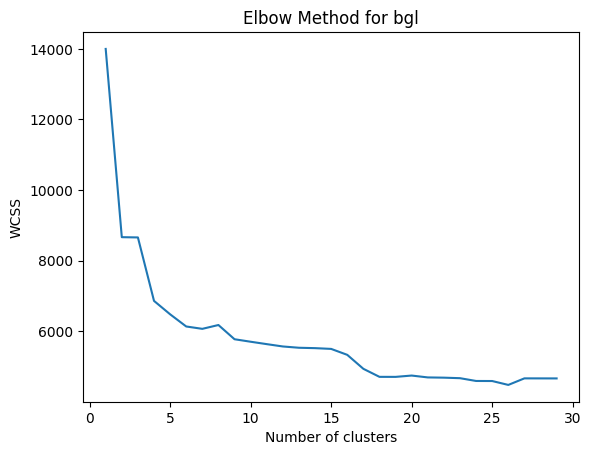

In [56]:
## Calculating Elbow

def clusters_elbow (unified_matrix, dataset):
    ## Clusters with cluster_kmedoids and silhouette score
    import matplotlib.pyplot as plt
    import matplotlib

    # Finding the optimal number of clusters using Elbow Method
    wcss = []
    max_clusters = 30
    for i in range(1, max_clusters):
        kmedoids = KMedoids(n_clusters=i, random_state=42)
        kmedoids.fit(unified_matrix)
        wcss.append(kmedoids.inertia_)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.plot(range(1, max_clusters), wcss)
    plt.title('Elbow Method for {}'.format(dataset))
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()    

def cluster_kmedoids_silhouette(unified_matrix, cluster_num):
    ## Clusters with cluster_kmedoids and silhouette score
    from sklearn.metrics import silhouette_score

    clusterer = KMedoids(n_clusters=cluster_num, random_state=42)
    #clusterer.fit(unified_matrix)
    #print("Para {} clusters, o silhouette score é {}".format(cluster_num,silhouette_score(unified_matrix, clusterer(unified_matrix))))
    print("Para {} clusters, o silhouette score é {}".format(cluster_num, silhouette_score(unified_matrix, clusterer.fit_predict(unified_matrix))))


dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

alpha = 0.3
beta = 0.4
gamma = 0.3
vector_df = transform(os.path.basename(logName))
distance_matrix = create_distance_matrix(vector_df)
variable_matrix = create_variable_matrix()
closeness_matrix = creates_closeness_matrix(distance_matrix)
joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
clusters_elbow(joint_matrix, dataset)

In [57]:
#cluster_kmedoids_silhouette(joint_matrix, 20)

for i in range (2,30):
    cluster_kmedoids_silhouette(joint_matrix, i)

Para 2 clusters, o silhouette score é 0.555929128650499
Para 3 clusters, o silhouette score é 0.07002702964854944
Para 4 clusters, o silhouette score é 0.3672270239911916
Para 5 clusters, o silhouette score é 0.3692600984353187
Para 6 clusters, o silhouette score é 0.2919297517241138
Para 7 clusters, o silhouette score é 0.2866827591642309
Para 8 clusters, o silhouette score é 0.22216780396007346
Para 9 clusters, o silhouette score é 0.24174398032298783
Para 10 clusters, o silhouette score é 0.2512194626720594
Para 11 clusters, o silhouette score é 0.25785586011449985
Para 12 clusters, o silhouette score é 0.26648702266148466
Para 13 clusters, o silhouette score é 0.2547833706596458
Para 14 clusters, o silhouette score é 0.24928914065545654
Para 15 clusters, o silhouette score é 0.24349399325216853
Para 16 clusters, o silhouette score é 0.2292731640595482
Para 17 clusters, o silhouette score é 0.2533668440231919
Para 18 clusters, o silhouette score é 0.25367015793340175
Para 19 cluster

In [7]:
## General parameters 

dataset = "Proxifier" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

Testing predefined clustering and raw data matrix with drain st 0.5, drain depth 5, min cluster size 0.7, min samples 0.2, cluster selection epsilon 0.1, alpha 5, and leaf size 5
The precision is 0.024242460317460357, the recall is 0.11371666666666658, the f1 score is 0.032262259662750356
*****
Testing predefined clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.0, alpha 1.0, and leaf size 40
The precision is 0.01561309523809528, the recall is 0.08391666666666658, the f1 score is 0.021333423289262778
Testing predefined clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 1, beta 0, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.0, alpha 1.0, and leaf size 40
The precision is 0.024242460317460357, the recall is 0.11371666666666658, the f1 score is 0.032262259662750356
Testing predefined clustering and precomputed matrix with drain

'The precision is 0.04464999999999988, the recall is 0.3217333333333341, the f1 score is 0.07209643337063033'

In [60]:
def tests_hdbscan(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
    clustering = cluster_hdbscan(joint_matrix, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

def tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, cluster_num):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, cluster_num {}".
          format(drain_st, drain_depth, alpha, beta, gamma, cluster_num))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix,alpha, beta, gamma)
    clustering = cluster_kmedoids(joint_matrix, cluster_num)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.3
beta = 0.4
gamma = 0.3
cluster_num = 2

#tests_hdbscan(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, 8)
tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, 20)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth,  0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")


Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.3, beta 0.4, gamma 0.3, cluster_num 8
The precision is 0.21934047619047772, the recall is 0.5385023809523839, the f1 score is 0.30430764386567183
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.3, beta 0.4, gamma 0.3, cluster_num 20
The precision is 0.2224547619047638, the recall is 0.5466690476190507, the f1 score is 0.3088331183687678


'The precision is 0.2224547619047638, the recall is 0.5466690476190507, the f1 score is 0.3088331183687678'

In [ ]:
tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

In [8]:
## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.9, leaf_size)
# tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.8, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, leaf_size)

Testing predefined clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.0, alpha 1.0, and leaf size 40
The precision is 0.09790496031746, the recall is 0.20224166666666718, the f1 score is 0.12862649979774687
Testing predefined clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.0, alpha 0.75, and leaf size 40
The precision is 0.10692817460317404, the recall is 0.21532499999999993, the f1 score is 0.1398958468749993
Testing predefined clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.0, alpha 0.5, and leaf size 40
The precision is 0.10592817460317405, the recall is 0.21332499999999988, the f1 score is 0.13856251355499927
Testing predefined clustering and pre

'The precision is 0.10175674603174564, the recall is 0.208525, the f1 score is 0.13367789827554033'

In [4]:
## General parameters 

dataset = "spark" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.2
beta = 0.1
gamma = 0.7
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

TypeError: tests_predefined_rawdata() takes 7 positional arguments but 10 were given

In [12]:
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 2, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 20, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 2, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 20, cluster_selection_epsilon, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 0.25, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 1, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, 2)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, 10)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 20)

tests_generated_precomputed(0.2, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(0.7, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(0.1, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)


Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 2, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.21889047619047822, the recall is 0.5466357142857173, the f1 score is 0.3049342172738324
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 10, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.22290476190476347, the recall is 0.5466357142857173, the f1 score is 0.3092675505844053
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 20, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.2204047619047635, the recall is 0.5459690476190502, the f1 score is 0.3066082099585741
Testing generated clustering and precomputed 

'The precision is 0.2210547619047639, the recall is 0.5456880952380979, the f1 score is 0.3071842495643068'

In [3]:
## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75
alpha_clustering = 0.25
leaf_size = 5

print ("teste com generated, raw data")
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, 20)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 40)

teste com generated, raw data
Testing generated clustering and raw data matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.2219547619047634, the recall is 0.5487547619047641, the f1 score is 0.3085791214071742
Testing generated clustering and raw data matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 20
The precision is 0.22070476190476354, the recall is 0.5389214285714313, the f1 score is 0.30576227158699276
Testing generated clustering and raw data matrix with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 40
The precision is 0.22099047619047768, the recall is 0.5439690476190503, the f1 score is 0.3069049132513597
Testing generated

'The precision is 0.21899047619047815, the recall is 0.5416119047619072, the f1 score is 0.3043960299925204'

In [5]:
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)


Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 20
The precision is 0.22269047619047777, the recall is 0.5463357142857174, the f1 score is 0.30900997483000603
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 20
The precision is 0.22149047619047774, the recall is 0.5442547619047644, the f1 score is 0.3073996342224408
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 5, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 20
The precision is 0.22079047619047784, the recall is 0.5406357142857173, the f1 score is 0.3061869645280193
Testing generated clustering and precomput

'The precision is 0.22440714285714447, the recall is 0.5446357142857179, the f1 score is 0.3109563117958716'

In [13]:
tests_generated_precomputed(drain_st, 2, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, 7, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, 10, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 2, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.22350476190476357, the recall is 0.5477785714285744, the f1 score is 0.31002773157455493
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 7, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.2169047619047641, the recall is 0.5474702380952405, the f1 score is 0.30256890158135746
Testing generated clustering and precomputed matrix with drain st 0.5, drain depth 10, alpha 0.5, beta 0.5, gamma 0, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 0.25, and leaf size 5
The precision is 0.22219047619047794, the recall is 0.5459214285714317, the f1 score is 0.30835201513205607


'The precision is 0.22219047619047794, the recall is 0.5459214285714317, the f1 score is 0.30835201513205607'

In [4]:
## General parameters 

dataset = "hdfs" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75
alpha_clustering = 1.0
leaf_size = 10

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)

Testing previous clustering with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 1.0, and leaf size 10
The precision is 0.06799999999999994, the recall is 0.16934999999999992, the f1 score is 0.09437618911321943
Testing previous clustering with drain st 0.3, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 1.0, and leaf size 10
The precision is 0.06216666666666657, the recall is 0.12985000000000005, the f1 score is 0.0812571418434352
Testing previous clustering with drain st 0.1, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 0.75, alpha 1.0, and leaf size 10
The precision is 0.0, the recall is 0.0, the f1 score is 0.0
Testing previous clustering with drain st 0.5, drain depth 3, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5, cluster selection epsilon 

'The precision is 0.2206047619047642, the recall is 0.5433690476190511, the f1 score is 0.30656685130716455'

In [12]:
## General parameters 

dataset = "hdfs" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.3, 0.4, 0.3, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

Testing previous clustering with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.09753333333333203, the recall is 0.292, the f1 score is 0.1460346437193026
Testing previous clustering with drain st 0.3, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.09753333333333203, the recall is 0.292, the f1 score is 0.1460346437193026
Testing previous clustering with drain st 0.1, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.09753333333333203, the recall is 0.292, the f1 score is 0.1460346437193026
Testing previous clustering with drain st 0.5, drain depth 3, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.09753333333333203, the recall is 0.292, the f1 

'The precision is 0.07859999999999832, the recall is 0.3660000000000002, the f1 score is 0.12883149978105463'

In [16]:
## General parameters 

dataset = "Zookeeper" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.3, 0.4, 0.3, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

Testing previous clustering with drain st 0.5, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
Iniciando encode
The precision is 0.055766666666667006, the recall is 0.08873333333333354, the f1 score is 0.0671143818715341
Testing previous clustering with drain st 0.3, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.05451666666666701, the recall is 0.08548333333333352, the f1 score is 0.06533965662714547
Testing previous clustering with drain st 0.1, drain depth 5, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The precision is 0.05696666666666701, the recall is 0.0897333333333335, the f1 score is 0.06844130494866518
Testing previous clustering with drain st 0.5, drain depth 3, alpha 0.7, beta 0.2, gamma 0.1, min cluster size 5, min samples 5 and cluster selection epsilon 0.75
The p

IndexError: list index out of range